##### Packages

In [1]:
using Plots, DifferentialEquations, Distributions, Random, LaTeXStrings, DataFrames, GLM, ProgressBars

##### First functions 

In [2]:
# Define CR dynamics for DifferentialEquations 

function CR!(dx,x,p,t)

    N,M,R = p
    dx[1:N] = x[1:N].*(R*x[1+N:N+M])
    dx[N+1:N+M] = -x[1+N:N+M].*(transpose(R)*x[1:N]) 
    
end
 
# Resource consumption 

function random_mat(N,M,S,Amag)

    A = rand(Float64, N*M);
    A[A .< S] .= 0;
    # since it's difficult to make a logical mask for a matrix i decided to use instead a flattened vector that i will 
    # reshape after the condition has been satisfied
    A = reshape(A, (N,M));
    # return A
    return A*Amag*N*M*M/sum(A)

end

# Defining initial conditions for X and Y for the first dilution cycle since in the successive both X0 and Y0 will 
# follow a a specific dynamics due to Y0 markov chain

function Y0s_fun(M,k,σ,steps,Ymag)
  
    Y0 = rand(M);
    Y0 /= sum(Y0);
    Y0 *= Ymag;

    Y0s = zeros((M,steps));
    Y0s[:,1] = Y0;

    for i in 2:steps
        tmp = Y0s[:,i-1] + σ*randn(M).*Y0 - k*(Y0s[:,i-1] - Y0)
        Y0s[:,i] = @. abs(tmp)
    end
    return Y0s
end

function Y0s_fun1(M,σ,steps,Y0)
  
    Y0s = zeros((M,steps));
    Y0s[:,1] .= Y0;

    for i in 2:steps
        tmp = Y0 .+ σ*randn(M)*Y0
        Y0s[:,i] = @. abs(tmp)
    end
    return Y0s
end

function final_cond(s)
    return transpose(hcat([s[i][end,:] for i in 1:length(s)]...))
end

final_cond (generic function with 1 method)

In [7]:
 function finds(N,M,R,D,steady_steps,tspanf,Y0s;ss = true)
    p = [N,M,R]
    tspan = (0.,tspanf)
    change_thresh = 0.05
    X0s = zeros((N,steady_steps+1));
    X0s[:,1] = ones(N)/N*100/D;
    sol = [[] for i=1:steady_steps]
    res = [[] for i=1:steady_steps]

    time_series = [[] for i=1:steady_steps]
    sol_mat = Matrix{Float64}[]
    res_mat = Matrix{Float64}[]

    for  j in 1:steady_steps 
        X0 = X0s[:,j]
        Y0 = Y0s 
        XY0 = vcat(X0,Y0)

        # function positivedomain(u,t,integrator)
        #     any(integrator.u[(N+1):(N+M)] .< 10e-6) == true
        # end

        # function zeroing!(integrator)
        #     integrator.u[(N+1):(N+M)][integrator.u[(N+1):(N+M)] .< 10e-6] .= 10e-6
        # end

        prob = ODEProblem(CR!, XY0, tspan, p)
        sol_tmp = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8);

        X0s[:,j+1] = sol_tmp.u[length(sol_tmp.u)][1:N]/D

        sol[j] = sol_tmp.u
        res[j] = sol_tmp.u
        sol[j] = [sol[j][i][1:N] for i in 1:length(sol[j])]
        res[j] = [res[j][i][N+1:(N+M)] for i in 1:length(res[j])]
        time_series[j] = sol_tmp.t
        
        tmp = zeros(length(sol[j]),N)
        for i in 1:length(sol[j])
            tmp[i,:] = sol[j][i]
        end
        push!(sol_mat,tmp)

        tmp_res = zeros(length(res[j]),M)
        for i in 1:length(res[j])
            tmp_res[i,:] = res[j][i]
        end
        push!(res_mat,tmp_res)

        print("$j ")
        ss == true && j >= 1 && sum((X0s[:,j+1]./X0s[:,j] .- 1) .< 0.05) == length(X0) && break 
        # here we verify that the sum of the boolean vector that results from the inequality condition is equal to 
        # the length of sol; that is element wise condition is verified for all the components of the difference vector
    end

    filt = [i for i in 1:length(sol) if sol[i] != []] 
    time_series = time_series[filt]

    return [sol_mat,res_mat],time_series

end

finds (generic function with 1 method)

In [14]:
# plot() function represents, starting from a matrix with NxM dimension, each column against the indices 
# coming from the length of those columns. We end up then with M lines.

#---Parameters of the simulation---

N = 1 
M = 1
S = 0.1
σ = 0.1
k = 1
D = 200
Amag = 0.001 
Ymag = 100
Ȳ = 50
steps = 1000
steady_steps = 1
tspanf = 500

xss = zeros(steps,N)
# Y0j = Y0s_fun(M,k,σ,steps,Ymag)
Y0j = Y0s_fun1(M,σ,steps,Ȳ)
R = random_mat(N,M,S,Amag)
yss = zeros(steps,M)
consumers = [];
resources = [];
times = [];

In [15]:
for i in 1:steps
    sr,t = finds(N,M,R,D,steady_steps,tspanf,Y0j[:,i]);
    s = sr[1]
    r = sr[2]
    Xfj = final_cond(s)
    Yfj = final_cond(r)
    xss[i,:] = Xfj[end,:]./D
    yss[i,:] = Yfj[end,:]
    # step useful to normalize the abundances in order to plot then relative abundances 
    # xss[i,:] ./= sum(xss[i,:])
    # yss[i,:] ./= sum(yss[i,:])
    push!(consumers,s)
    push!(resources,r)
    push!(times,t)
end

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

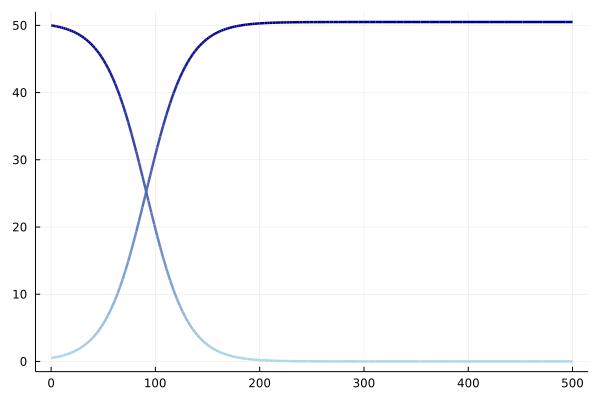

In [16]:
plot(times[1][1],consumers[1][1],legend=false, color=:blues,line_z=consumers[1][1],linewidth=2.5)
plot!(times[1][1],resources[1][1],legend=false, color=:blues,line_z=resources[1][1],linewidth=2.5)


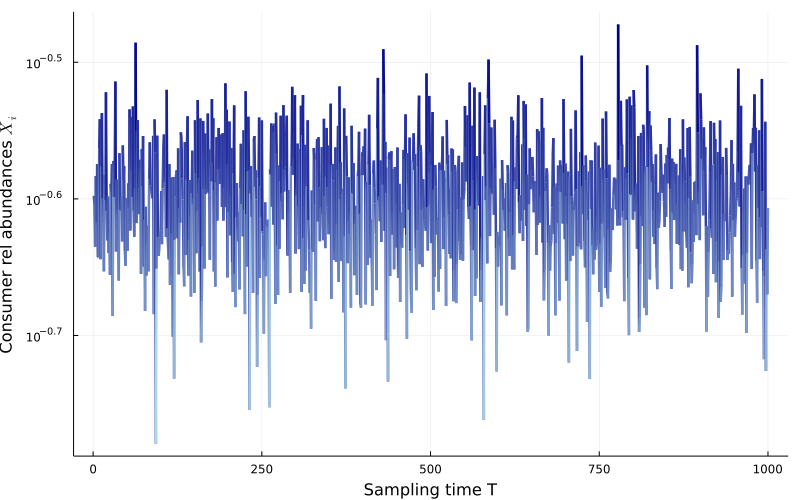

In [18]:
plot(xss,yaxis=:log10,legend=false,size=(800,500),line_z=log.(xss),color=:blues,linewidth=2.5,
     xlabel="Sampling time T",ylabel="Consumer rel abundances "*L" X_i")

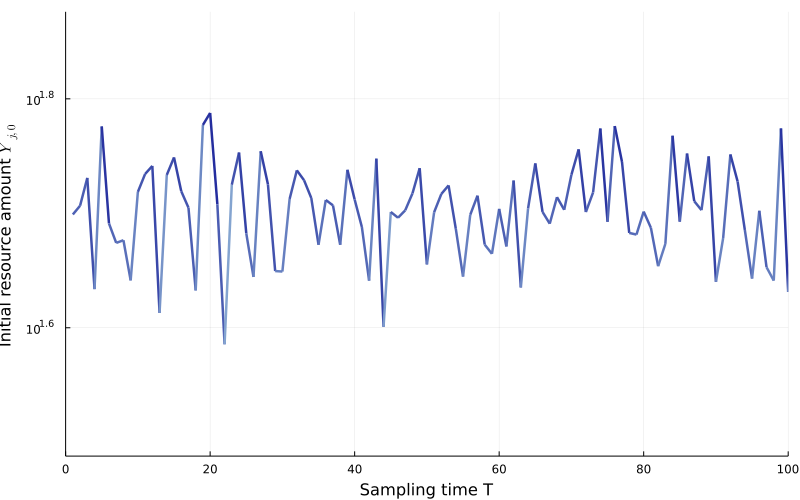

In [39]:
plot(transpose(Y0j),yaxis=:log,xlim=(0,100),legend=false,size=(800,500),line_z=log.(transpose(Y0j)),color=:blues,linewidth=2.5,
     xlabel="Sampling time T",ylabel="Initial resource amount "*L" Y_{j,0}")

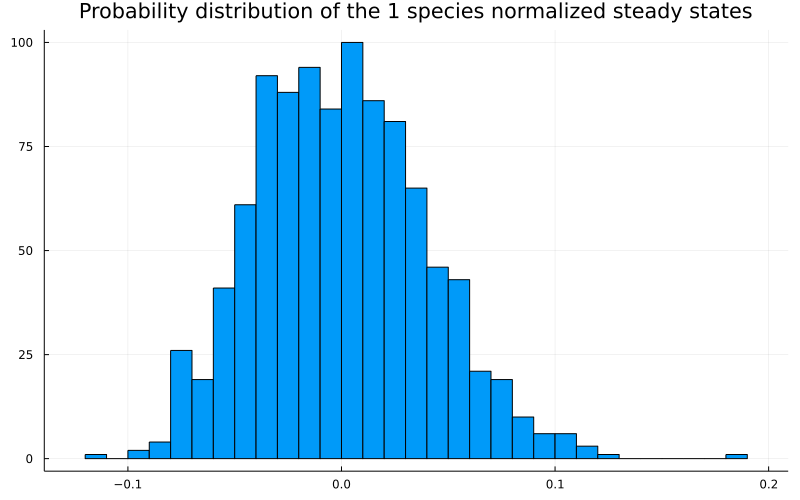

In [42]:
norm_mean = [mean(xss[:,i]) for i in 1:N]
norm_var = [var(xss[:,i]) for i in 1:N]
# norm_xss = [xss[:,i]/norm_mean[i] for i in 1:N]
norm_xss = [(xss[:,i] .- norm_mean[i]) for i in 1:N]
histogram(norm_xss,density=:true,legend=false,
          title="Probability distribution of the $N species normalized steady states", size=(800,500))

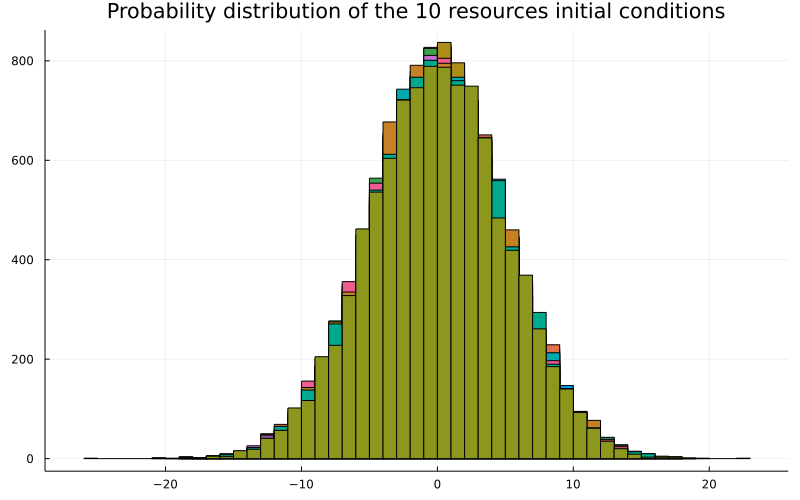

In [21]:
Y0 = transpose(Y0j) 
norm_Y0 = [Y0[:,i] .- mean(Y0[:,i]) for i in 1:N]
histogram(norm_Y0,density=:true,legend=false,
          title="Probability distribution of the $N resources initial conditions", size=(800,500))